## Patient Data Visualisation

#### Data Preprocessing

In [1]:
#importing necessary libraries
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [2]:
#Establishing connection
with open('config.yaml','r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.Loader)

    Conf = config['database']
    user = Conf['uid']
    password = Conf['password']

conn = pyodbc.connect(
    'Driver={ODBC Driver 17 for SQL Server};'
    'Server=localhost;'
    'Database=master;'
    'uid=%s;'
    'pwd=%s;'
    'MARS_Connection=Yes' % (user,password))

In [3]:
#Preprocessing Fucntions
def sql_reader(table):
    query = "SELECT * from [dbo].[%s]" % (table);
    table = pd.read_sql(query, conn)
    return table

def encounter_timestamp(row):
    if row['period_start'] < row['period_end']:
        val = row['period_end']
    else:
        val = row['period_start']
    return val

def procedure_timestamp(row):
    if row['performedPeriod_start'] < row['performedPeriod_end']:
        val = row['performedPeriod_end']
    else:
        val = row['performedPeriod_start']
    return val

def col_rename(table,t_filter):
    table.rename(columns=col_info.loc[col_info['table_name'] == t_filter].set_index(['column_name'])['alias'], inplace=True)
    
def extract_datetime(table,time_col): 
    table[time_col] = pd.to_datetime(table[time_col])
    table['date'] = table[time_col].dt.date
    table[time_col] = table[time_col].dt.time
    
def merge_op(df1,df2,df1_params,df2_params,join_param,join_cond):
    df = pd.merge(df1[df1_params],df2[df2_params],on=join_param,how=join_cond)
    return df

def update_params(table):
    df_params = list(table.columns)
    return df_params

In [4]:
#Fetching dfs
encounter_df = sql_reader("encounter")
condition_df = sql_reader("condition")
procedure_df = sql_reader("procedure")
observation_df = sql_reader("observation")
medicationrequest_df = sql_reader("medicationrequest")

In [5]:
#Fetching data dictionary
col_info = pd.read_csv('col_info.csv')

In [6]:
#Creating timestamps
encounter_df['time_stamp'] = encounter_df.apply(encounter_timestamp, axis=1)
procedure_df['p_time_stamp'] = procedure_df.apply(procedure_timestamp, axis=1)

In [7]:
#Renaming columns
col_rename(encounter_df,'encounter_df')
col_rename(condition_df,'condition_df')
col_rename(procedure_df,'procedure_df')
col_rename(observation_df,'observation_df')
col_rename(medicationrequest_df,'medicationrequest_df')

In [8]:
#Extracting date-time features
extract_datetime(encounter_df,'time_stamp')
extract_datetime(condition_df,'c_time_stamp')
extract_datetime(procedure_df,'p_time_stamp')
extract_datetime(observation_df,'o_time_stamp')
extract_datetime(medicationrequest_df,'m_time_stamp')

In [9]:
#Mergings dfs together
encounter_params = ['patient_id','encounter_id','date','time_stamp','encounter_class','encounter_type','encounter_reason']
condition_params = ['patient_id','encounter_id','condition_code','date','c_time_stamp','clinical_status']
procedure_params = ['patient_id','encounter_id','procedure_reason','date','p_time_stamp','procedure_code']
observation_params = ['patient_id','encounter_id','date','o_time_stamp','observation_code','observation_unit',
                      'observation_value','observation_valueString','obervation_coding','component_code',
                      'component_value','component_unit','observation_text']
medication_params = ['patient_id','encounter_id','m_time_stamp','date','dose_quantity','dose_additional_instruction',
                     'medication_type','dose_repeat_timeperiod','dose_repeat_frequency','dose_as_needed',
                     'dose_repeat_timeunit','dose_sequence','dose_add_instruct_text']

on_condition = ['patient_id','encounter_id','date']

join_type = "left"

df = merge_op(encounter_df,condition_df,encounter_params,condition_params,on_condition,join_type)
df_params = update_params(df)
df = merge_op(df,procedure_df,df_params,procedure_params,on_condition,join_type)
df_params = update_params(df)
df = merge_op(df,observation_df,df_params,observation_params,on_condition,join_type)
df_params = update_params(df)
df = merge_op(df,medicationrequest_df,df_params,medication_params,on_condition,join_type)

In [11]:
df['procedure_code'].value_counts()

Documentation of current medications                        3804
Spirometry (procedure)                                       620
Electrical cardioversion                                     369
Auscultation of the fetal heart                              259
Evaluation of uterine fundal height                          259
                                                            ... 
Plain chest Xray (procedure)                                   1
Vasectomy                                                      1
Antenatal RhD antibody screening                               1
Seizure Count Cerebral Cortex Electroencephalogram (EEG)       1
RhD passive immunization                                       1
Name: procedure_code, Length: 78, dtype: int64

## Visualisation

#### Getting all libraries for supporting visualisation tasks

In [12]:
#add necessary libraries
import networkx as nx #library supporting networks
import scipy.stats as stat 
import statsmodels.formula.api as smf

#### Visualising Patient Portfolio 

In [77]:
df['component_value'] = df['component_value'].replace(['nan', 'None'], None)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


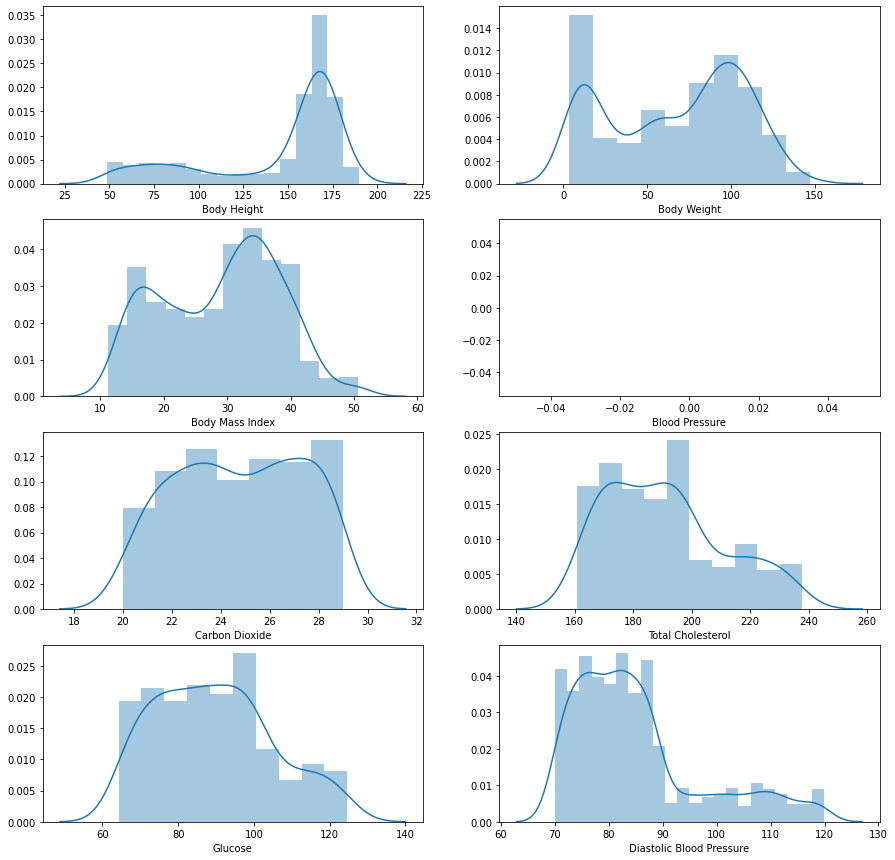

In [78]:
f, axes = plt.subplots(4, 2, figsize=(15, 15))
sns.distplot(df.loc[(df['observation_code']=='Body Height'),['observation_value']],axlabel= "Body Height",ax=axes[0,0])
sns.distplot(df.loc[(df['observation_code']=='Body Weight'),['observation_value']],axlabel= "Body Weight",ax=axes[0,1])
sns.distplot(df.loc[(df['observation_code']=='Body Mass Index'),['observation_value']],axlabel= "Body Mass Index",ax=axes[1,0])
sns.distplot(df.loc[(df['observation_code']=='Blood Pressure'),['observation_value']],axlabel= "Blood Pressure",ax=axes[1,1])
sns.distplot(df.loc[(df['observation_code']=='Carbon Dioxide'),['observation_value']],axlabel= "Carbon Dioxide",ax=axes[2,0])
sns.distplot(df.loc[(df['observation_code']=='Total Cholesterol'),['observation_value']],axlabel= "Total Cholesterol",ax=axes[2,1])
sns.distplot(df.loc[(df['observation_code']=='Glucose'),['observation_value']],axlabel= "Glucose",ax=axes[3,0])
sns.distplot(df.loc[(df['component_code']=='Diastolic Blood Pressure'),['component_value']],axlabel= "Diastolic Blood Pressure",ax=axes[3,1])

Multi-modal distribution with skew near 0 for body weight (using non 0 filled data); could be a possible error while recording data

In [13]:
#Filling NA values with 0 to support viz and conveniently convert columns to float
df = df.fillna(0)

#### Visualising common encounter-procedure combinations across all encounter categories

In [14]:
#Merging encounter with procedure and filtering out values less than 25 within each dataset
encounter_procedure_study = df[(df.groupby('encounter_reason')['encounter_reason'].transform('size') > 25)&(df.groupby('procedure_code')['procedure_code'].transform('size') > 25)]

In [15]:
#Creating an encounter-procedure graph to visualise the linkages between each encounter and each procedure
encounter_procedure=nx.DiGraph()
for i in encounter_procedure_study.index:
   encounter_procedure.add_edge(encounter_procedure_study.encounter_reason[i],encounter_procedure_study.procedure_code[i])  

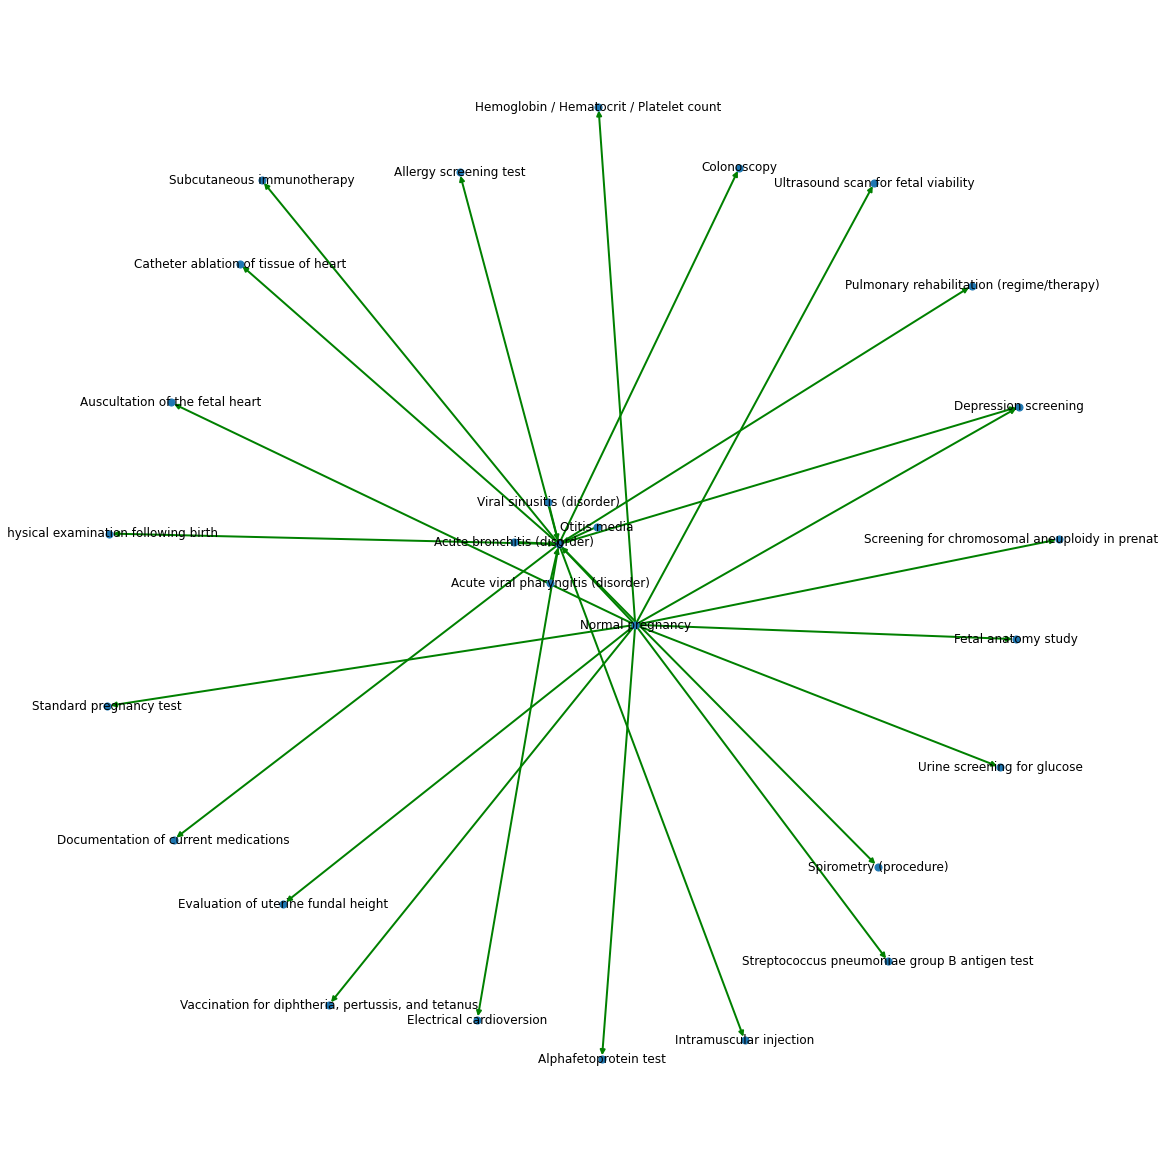

In [16]:
#visualize the encounter-procedure newtork
plt.figure(figsize = (16,16))
nx.draw(encounter_procedure,node_size=50,width=2,edge_color='green',with_labels=True)

 Encounters-Procedures are mostly independent within each encounter category with non-overlapping edges.

In [18]:
#Making dictionary for displaying top network edges and their corresponding centrality scores
def topdict(d,tn):
    ind=sorted(d, key=d.get, reverse=True)
    for i in range(0,tn):
       print('{0}|{1} : {2}'.format(i+1,ind[i],d[ind[i]]))
    return ind

In [19]:
#Getting list of top edges in the network
alpha = 0.95
pager = nx.pagerank(encounter_procedure,alpha)
print('Pagerank for alpha = {}'.format(alpha))
ind = topdict(pager,5)

Pagerank for alpha = 0.95
1|0 : 0.1400823250725513
2|Depression screening : 0.03949561955443764
3|Spirometry (procedure) : 0.037561259832935456
4|Colonoscopy : 0.037561259832935456
5|Documentation of current medications : 0.037561259832935456


Depression Screening, Spirometry, Colonoscopy and Documentation are procedures performed most commonly across patients with different complications

#### Second type visualisation (without filling 0's)

In [20]:
#Merging encounter with procedure and filtering out values less than 25 within each dataset
encounter_procedure_study = df[(df.groupby('encounter_reason')['encounter_reason'].transform('size') > 15)&(df.groupby('procedure_code')['procedure_code'].transform('size') > 15)]

In [21]:
#Creating an encounter-procedure graph to visualise the linkages between each encounter and each procedure
encounter_procedure=nx.DiGraph()
for i in encounter_procedure_study.index:
   encounter_procedure.add_edge(encounter_procedure_study.encounter_reason[i],encounter_procedure_study.procedure_code[i])  

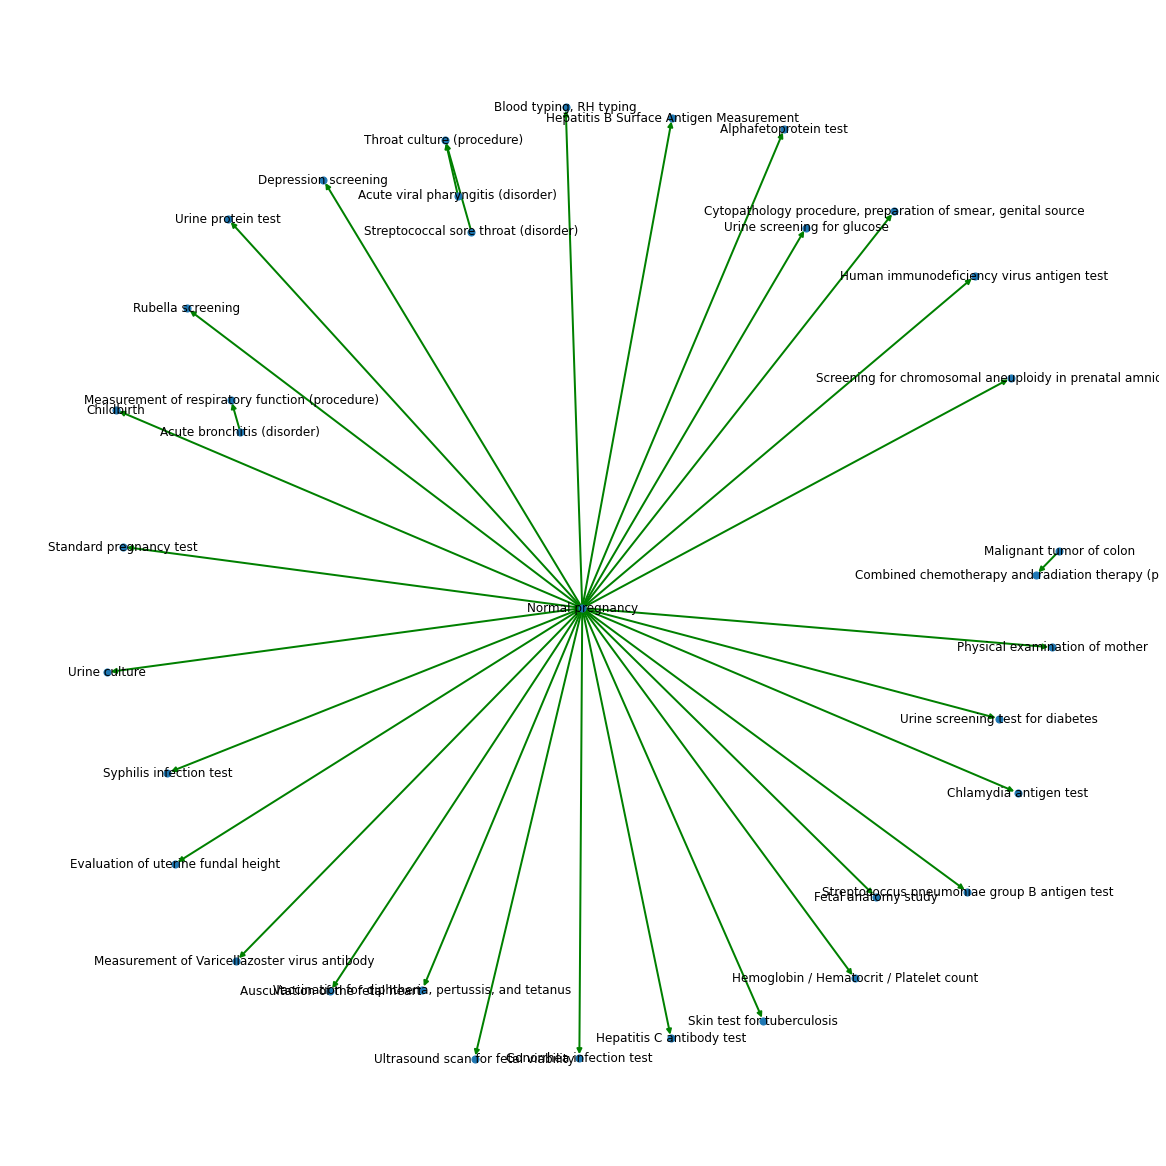

In [22]:
#visualize the encounter-procedure newtork
plt.figure(figsize = (16,16))
nx.draw(encounter_procedure,node_size=50,width=2,edge_color='green',with_labels=True)

In [23]:
#Getting list of top edges in the network
alpha = 0.95
pager = nx.pagerank(encounter_procedure,alpha)
print('Pagerank for alpha = {}'.format(alpha))
ind = topdict(pager,5)

Pagerank for alpha = 0.95
1|Throat culture (procedure)  : 0.07116541523532743
2|Combined chemotherapy and radiation therapy (procedure) : 0.04785265481037537
3|Measurement of respiratory function (procedure) : 0.04785265481037537
4|Evaluation of uterine fundal height : 0.025372492972028742
5|Auscultation of the fetal heart : 0.025372492972028742


Throat culture coming up as most commonly performed surgery could mean that patients with the hospital who are predominantly pregnant women (sample) have also undergone with ENT complications

#### Visualising common historical occurences, co-morbidites and preconditions amongst patient groups

In [24]:
#Merging encounter with condition and filtering out values less than 5 within each dataset
encounter_condition_study = df[(df.groupby('encounter_reason')['encounter_reason'].transform('size') > 5)&(df.groupby('condition_code')['condition_code'].transform('size') > 5)]

In [25]:
#Creating an encounter-condition graph to visualise the linkages between prior conditions and current encounters
encounter_condition=nx.DiGraph()
for i in encounter_condition_study.index:
   encounter_condition.add_edge(encounter_condition_study.condition_code[i],encounter_condition_study.encounter_reason[i])  

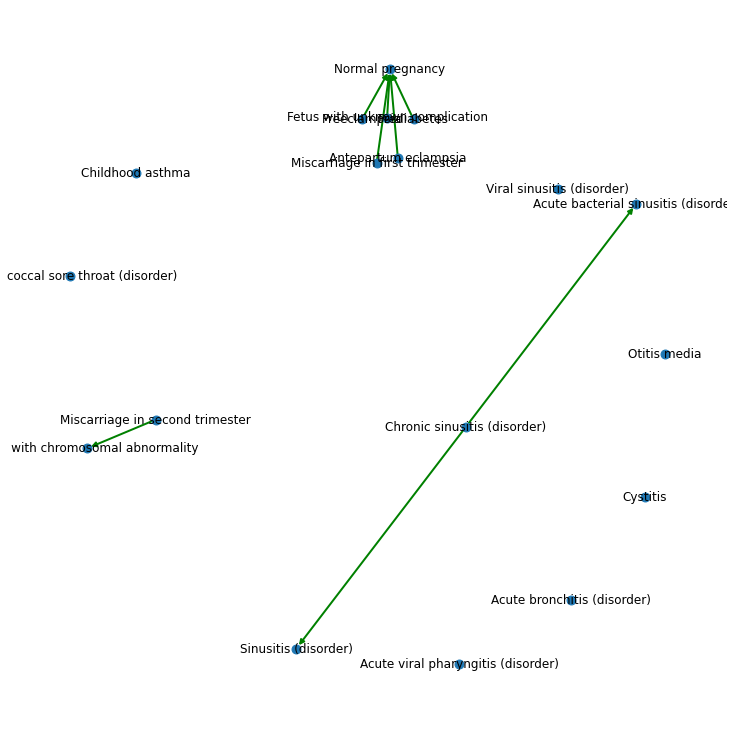

In [27]:
#Visualising the encounter-condition newtork
plt.figure(figsize = (10,10))
nx.draw(encounter_condition,node_size=80,width=2,edge_color='green',with_labels=True)

From the network graph, it is evident that the hospital needs to be more careful with patients with preganancy. Miscariages, Unknown Fetus Complications, Eclampsia are all common conditions amongst pregnant population. 


Other common conditions that co-exist with encounters that patients come to get checked are Chronic Sinusitis with a history of Sinusitis. Sinusitis is itself closely related with Pharyngitis and Bronchitis.

### Visualising encounters due to possible complications not properly treated within the hospital and risks of readmissions

In [28]:
#Making list of select complications that can result in re-encounters
complications_list = ['Combined chemotherapy and radiation therapy (procedure)','Childbirth','Cesarean section',
                     'Episiotomy','Epidural anesthesia']

In [29]:
#Filtering complications from list
complications_study = pd.DataFrame(df[(df['procedure_code']!= 0)&(df['procedure_code'].isin(complications_list))])[['patient_id','date','procedure_code','encounter_reason']]

In [46]:
#Defining a function for easier cross-tabbing of two categorical variables
def plot_cross_tab_chart(data,col1,col2):
    cross_tab = pd.crosstab(index=data[col1], columns=data[col2])
    cross_tab.plot(kind="bar", figsize=(15,10),stacked=True)

<Figure size 360x360 with 0 Axes>

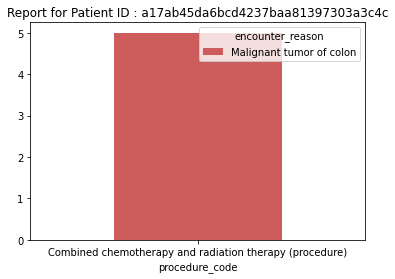

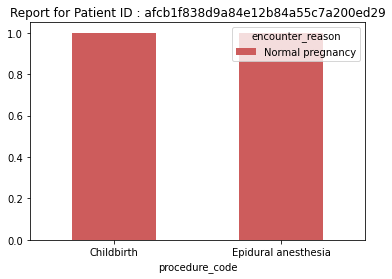

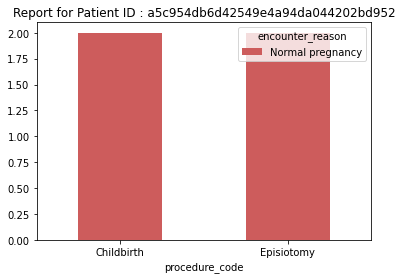

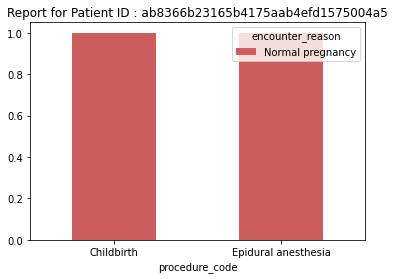

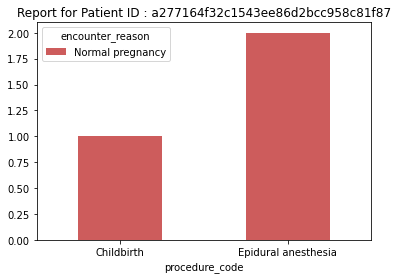

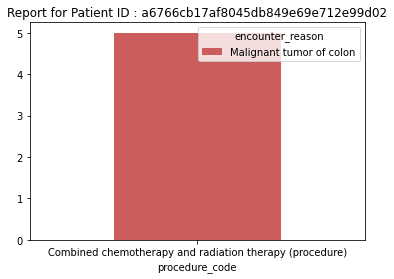

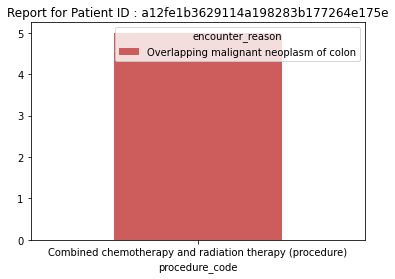

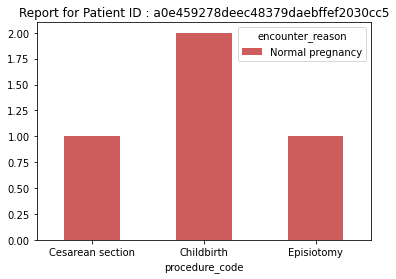

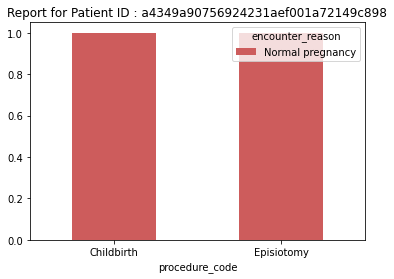

In [32]:
#Visualising re-admissions of patients after patient has undergone their first procedure with the hospital

#Getting all unique patient IDs
patients_wcomplications = complications_study['patient_id'].unique()

plt.figure(figsize = (5,5))

for patient in patients_wcomplications:
    ct = complications_study[complications_study['patient_id']==patient]
    ct = ct[ct['date']>ct['date'].min()]
    if ct.shape[0]>0:
        ct = pd.crosstab(ct['procedure_code'],ct['encounter_reason'])
        ct.plot(kind="bar",color='indianred')
        plt.xticks(rotation=0)
        plt.title("Report for Patient ID : {}".format(patient))

According to the graphs, there are no procedures that could have resulted in other encounters amongst the patients. Example, patients have had normal pregnancies after episiotomy and cesarean sections. 

It can also be seen that tumor has been a common occurence amongst patients receiving Chemotherapy. But it could be a result of continuous chemo sessions undertaken by the patients long ahead in the future after the cancer was detected and therefore might not have a causation due to chemotherapy

In [33]:
#Other way to visualise the above information
Encounter=nx.DiGraph()
for i in complications_study.index:
   Encounter.add_edge(complications_study.procedure_code[i],complications_study.encounter_reason[i])  

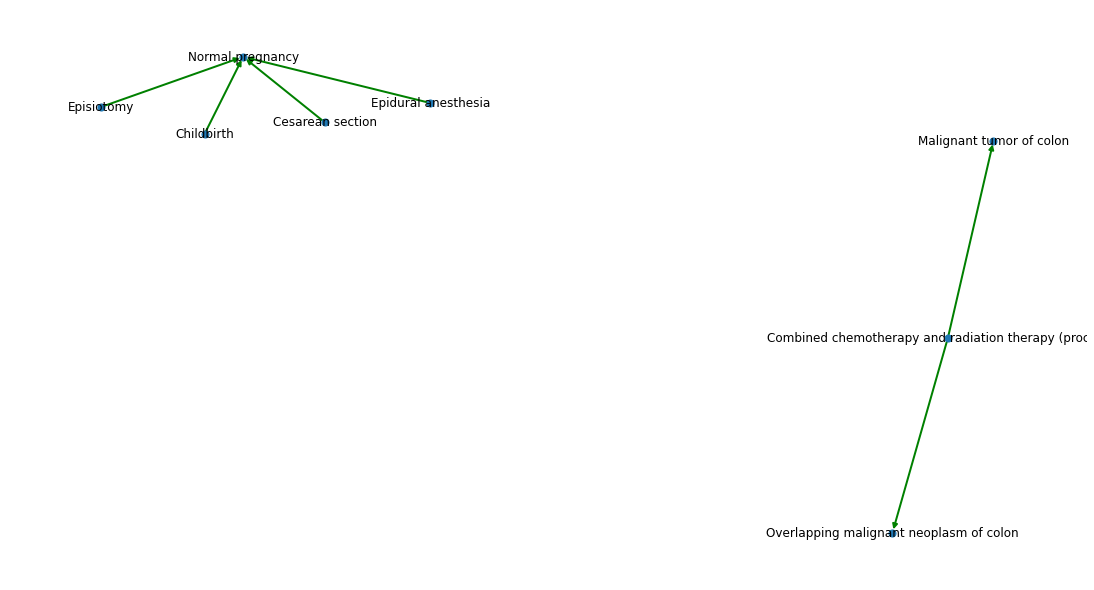

In [34]:
#visualize the procedure-encounter newtork
plt.figure(figsize = (15,8))
nx.draw(Encounter,node_size=50,width=2,edge_color='green',with_labels=True)

#### Visualising Re-Admissions amongst patients

In [35]:
#Making dictionaries for first encounter and mode of subsequent encounters
first_encounter = {}
second_encounter = {}

patients_subq = df['patient_id'].unique()

for patient in patients_subq:
    # Getting first non-null encounter of the patient with the respective hospital
    first_non_null = df['encounter_reason'][df['patient_id']==patient]
    try:
        first_encounter[patient] = first_non_null.loc[first_non_null.first_valid_index()]
    except:
        continue
    # Getting frequent encounters of the patient after first encounter
    second_enc = df['encounter_reason'][df['patient_id']==patient].mode()[0]
    second_encounter[patient] = second_enc

In [36]:
#Making the readmissions dataframe
first_encounter = pd.DataFrame(first_encounter.items(),columns={'id','first_encounter'})
first_encounter = first_encounter.rename(columns={'id':'first_encounter','first_encounter':'id'})
second_encounter = pd.DataFrame(second_encounter.items(),columns={'id','freq_encounter'})
second_encounter = second_encounter.rename(columns={'id':'freq_encounter','freq_encounter':'id'})
readmissions = first_encounter.merge(second_encounter,on='id',how='left')

In [37]:
#Defining a stacking plot function
def stack_plot(data,col, target, ax=None):
    
    #palette = ['#ff0000', '#fbd082', '#80ffc3', '#a3cc00' , '#0088ff', '#d9bfff', '#a6296c', '#8c4646', '#ff8800', '#5e664d', '#269991', '#d1dd4a', '#7e468c', '#d96236', '#7f2200']

    #palette = ['#fbd082', '#d1dd4a', '#e5d62e', '#2484bc', '#cbbeb5', '#696966', '#f3ebe8', '#b5ced8',' #cee5ce', '#89c1a5', '#eeeeee', '#9cb0c3','#e081a8', '#e4a4ba', '#d8725f', '#ed9481', '#5bbbeb', '#22324e', '#007dd7', '#272c67'] 
    
    palette = ['#641E16','#ff0000','#C0F312','#7FF312','#12F3AF','#12F3E2','#12B5F3','#7290E5','#9372E5','#270381','#C31DF0','#F01D66','#d1dd4a','#BDBABF','#44245B','#C27308','#FAFD31','#FD7531','#FD3131','#0A921B']

    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')
    props.plot(kind="barh", stacked=True,figsize=(20,20), color=palette)

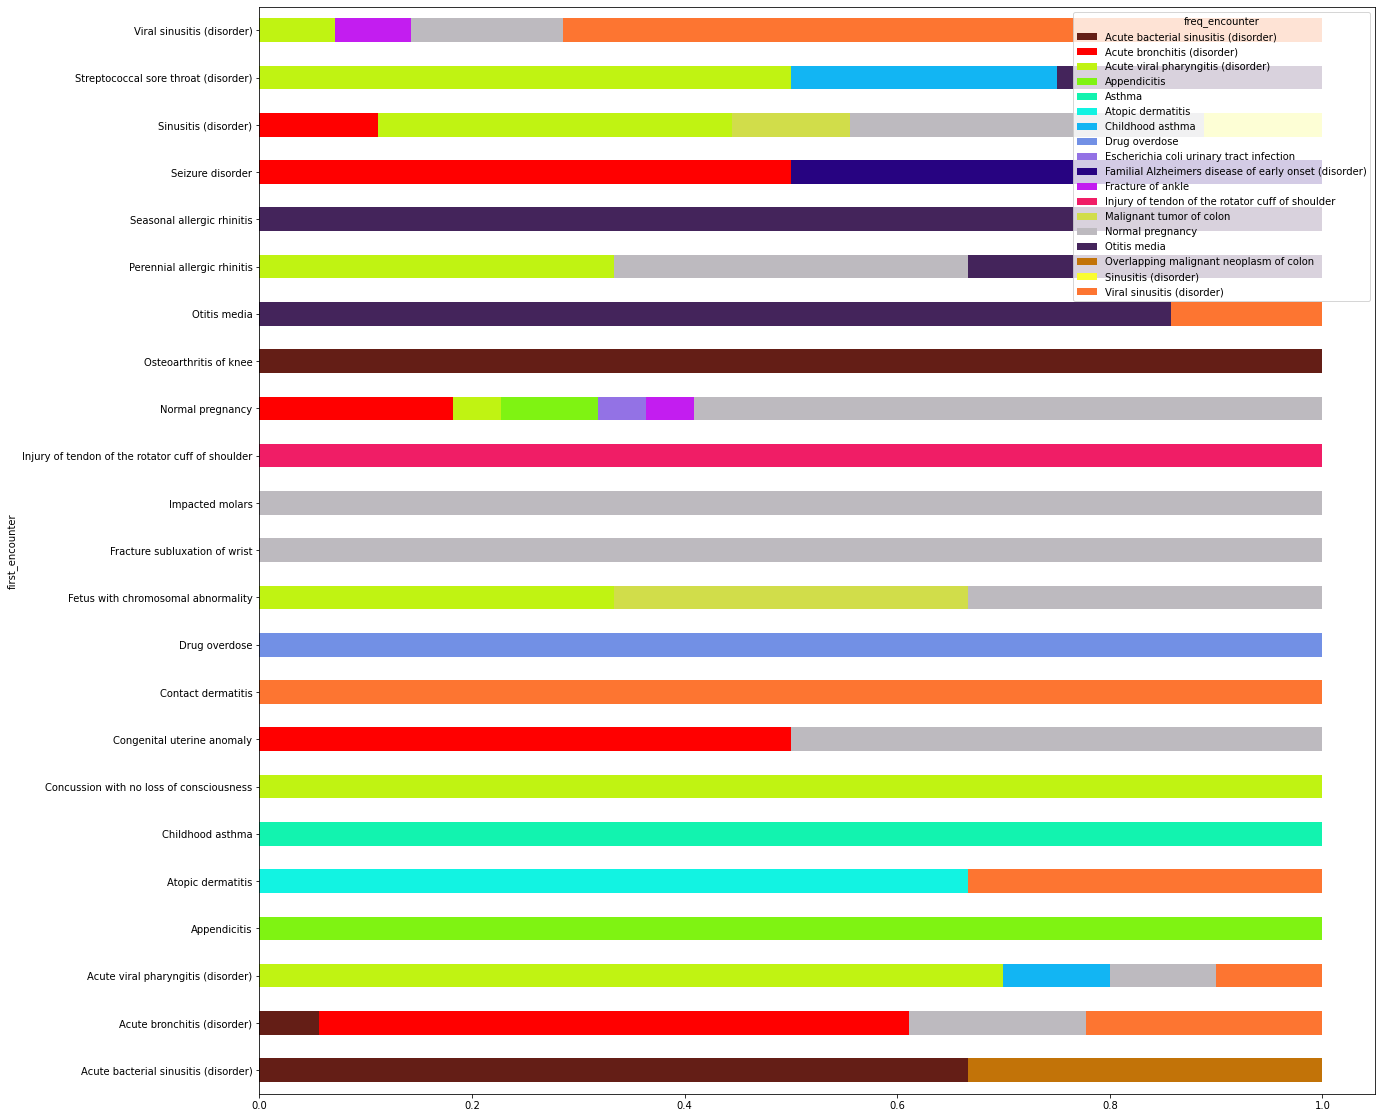

In [38]:
stack_plot(readmissions,'first_encounter', 'freq_encounter')

Patients having sore throat are also found to have pharyngitis and otitis media frequently.

Pregnant women are sometimes faced with uninary tract infection. 

Brochitis and Sinusitis follow one another. 

Data skewed with a lot of pregnancy related datapoints and we see relationships with pregnancies more frequently

#### Understanding co-morbidities amongst patients

In [39]:
#Merging encounters with conditions
comorbidities = pd.merge(encounter_df[encounter_params],condition_df[condition_params],on=['patient_id','encounter_id','date'],how='left')
comorbidities.head()

,patient_id,encounter_id,date,time_stamp,encounter_class,encounter_type,encounter_reason,condition_code,c_time_stamp,clinical_status
0,a17ab45da6bcd4237baa81397303a3c4c,a2b092379ea33401a86d39925dc484bf1,1980-01-30,21:41:50,ambulatory,Prenatal visit,Fetus with chromosomal abnormality,Miscarriage in second trimester,20:56:50,active
1,a17ab45da6bcd4237baa81397303a3c4c,a2cb445bdb4e646f1ba13b3b8b569bc83,1984-10-03,21:26:50,WELLNESS,Encounter for check up (procedure),None,Chronic obstructive bronchitis (disorder),20:56:50,active
2,a17ab45da6bcd4237baa81397303a3c4c,aab589a054198436b9dd8d70093464ff6,1987-10-07,21:41:50,WELLNESS,Encounter for check up (procedure),None,NaN,NaN,NaN
3,a17ab45da6bcd4237baa81397303a3c4c,af29e6e3497034c3d96bf2b978dce2652,1996-07-31,21:26:50,WELLNESS,Encounter for check up (procedure),None,Prediabetes,20:56:50,active
4,a17ab45da6bcd4237baa81397303a3c4c,a77d86aa326fe4f50b85f1f001da80ea6,2010-03-10,21:26:50,WELLNESS,Encounter for check up (procedure),None,NaN,NaN,NaN


Assumption :  clinical status means patients having a previous occuring active or resolved complication

In [40]:
comorbidities['clinical_status'].value_counts(normalize=True) * 100

resolved    69.745223
active      30.254777
Name: clinical_status, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

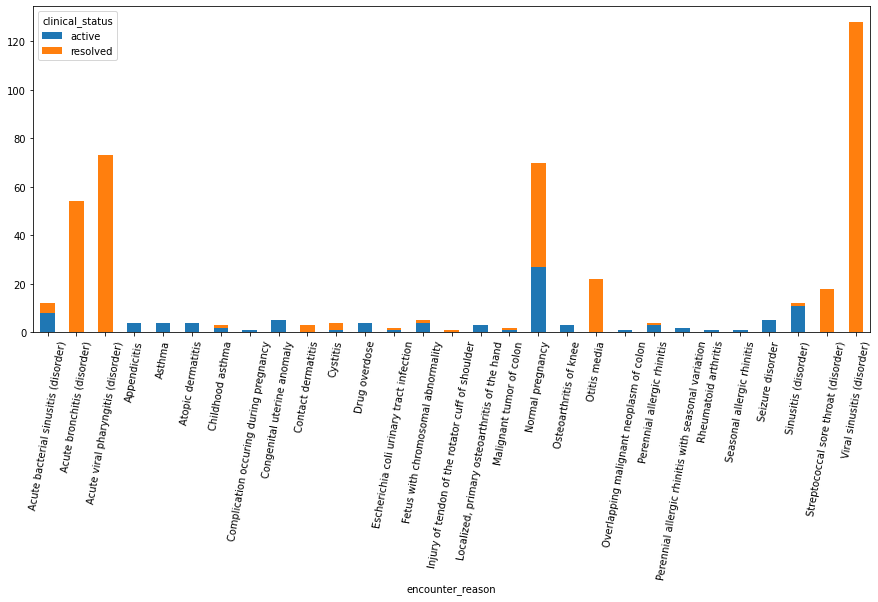

In [52]:
#Plotting encounters with active or resolved clinical status
comorbidities.groupby(['clinical_status', 'encounter_reason']).size().reset_index().pivot(columns='clinical_status',index='encounter_reason', values=0).plot(kind='bar', stacked=True,figsize=(15,6))
plt.xticks(rotation = 80)

Pregnancy has the most number of active conditions while they were brought in for labour. Breathing problems usually have active complications too in the form of childhood asthma or other breathing conditions.

In [42]:
#Filtering for values greater than 15
comorbidities_plot = comorbidities[comorbidities.groupby('encounter_reason')['encounter_reason'].transform('size') > 15]

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

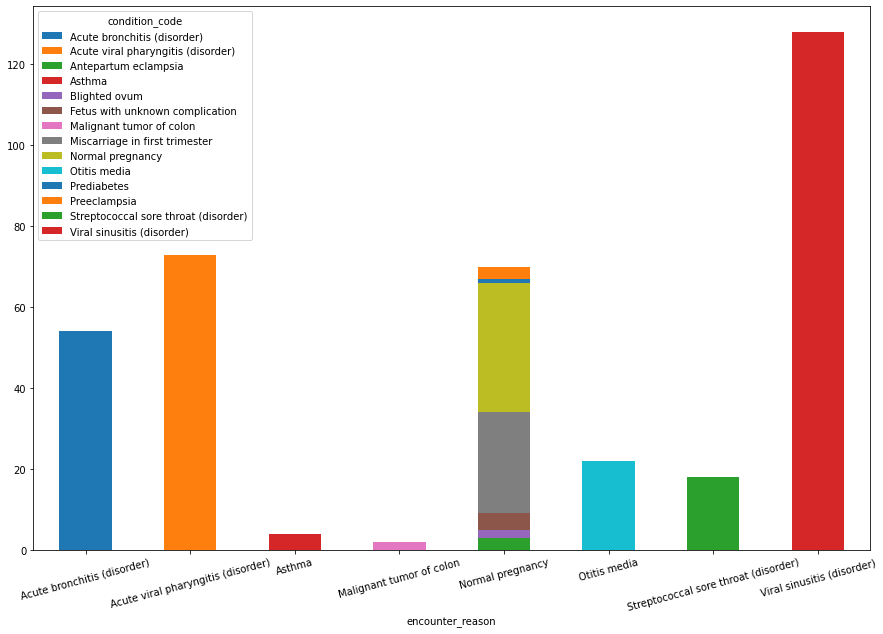

In [48]:
#Plotting historical conditions with current encounters
plot_cross_tab_chart(comorbidities_plot,'encounter_reason','condition_code')
plt.xticks(rotation = 15)

Pregnant women have had pre-conditions of miscarriages and blighted ovum. 

People with sore throat have had eclampsia. 

In [53]:
#Defining a function for box-plotting
def box_plot(df,x,y,xlab,ylab):
    fig = plt.figure(figsize=(15, 6))
    plt.xticks(rotation=90)
    sns.boxplot(df[x], df[y]).set(xlabel=xlab, ylabel=ylab)
    plt.xticks(rotation=60)

In [54]:
#Merging condition and observations together
condition_analysis = pd.merge(observation_df[observation_params],condition_df[condition_params],on=['patient_id','encounter_id','date'],how='left')
condition_analysis['component_value'] = condition_analysis['component_value'].replace(['nan', 'None'], None)
condition_analysis = condition_analysis.fillna(0)
condition_analysis['observation_value'] = condition_analysis['observation_value'].astype(float)
condition_analysis['component_value'] = condition_analysis['component_value'].astype(float)

<ipython-input-53-fc330b65a977>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15, 6))


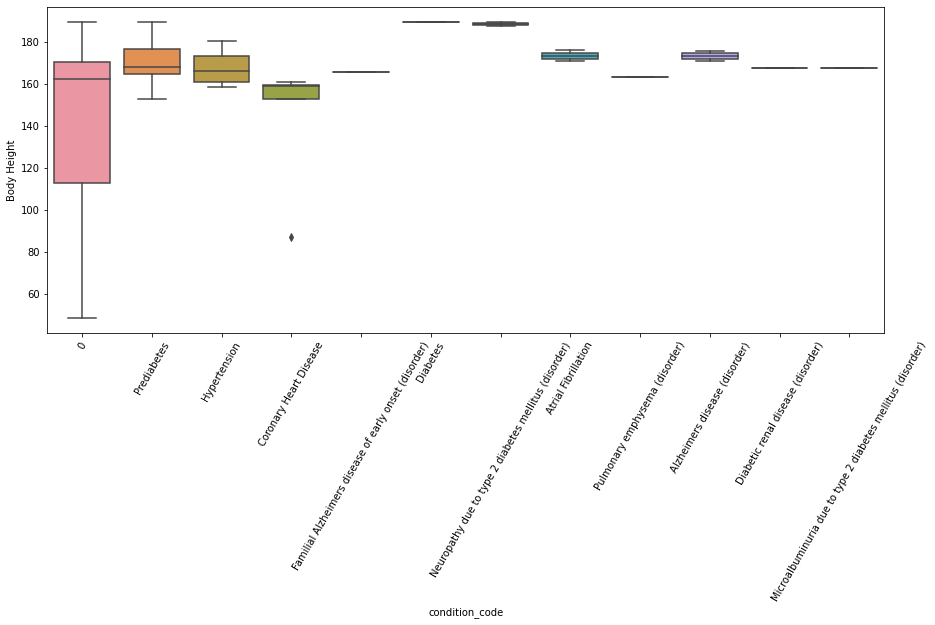

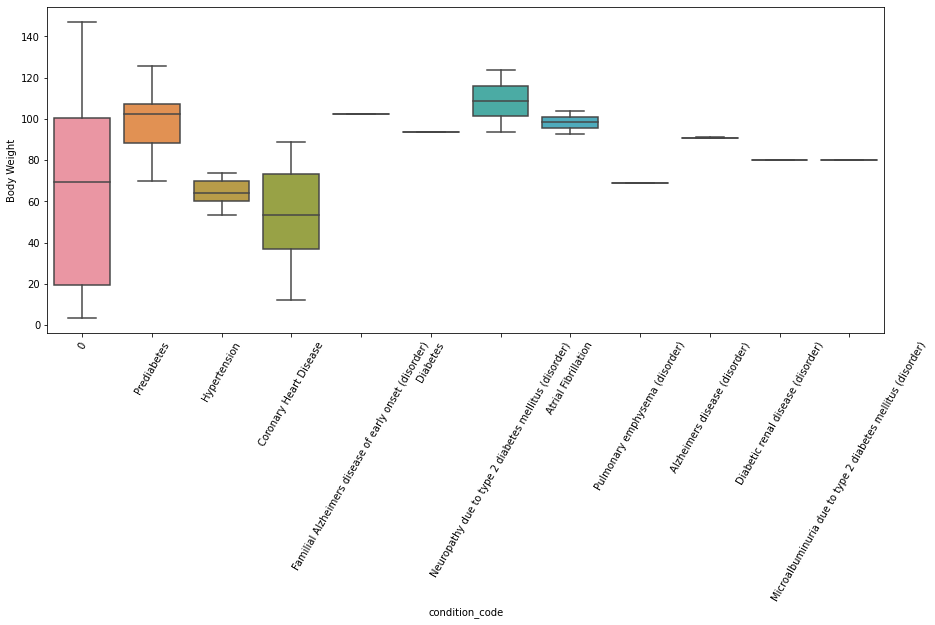

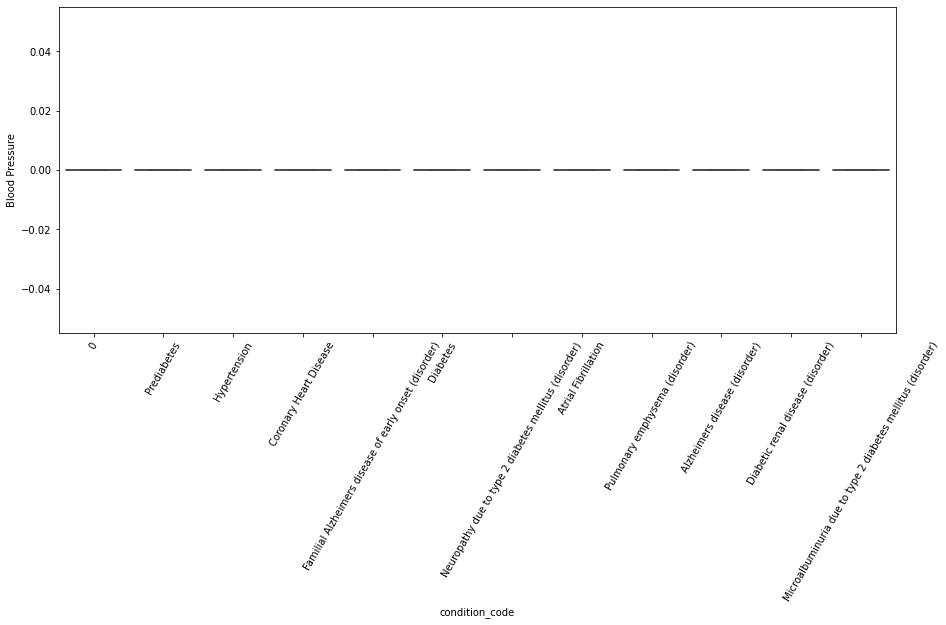

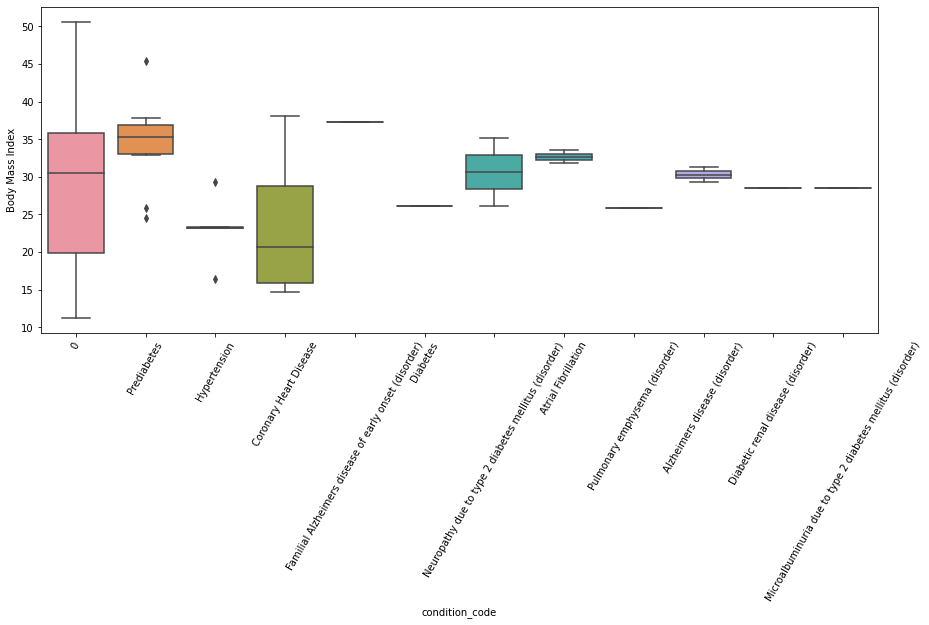

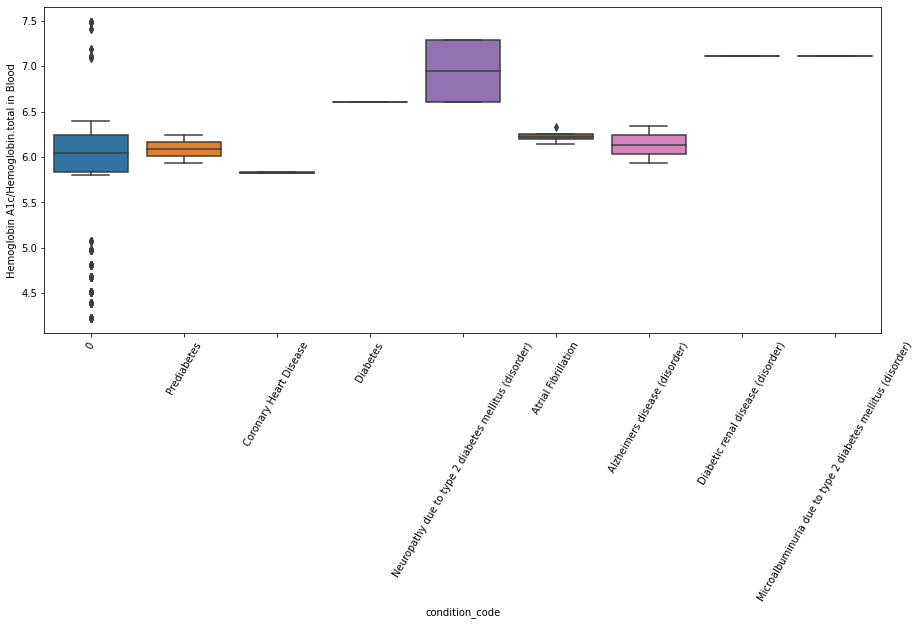

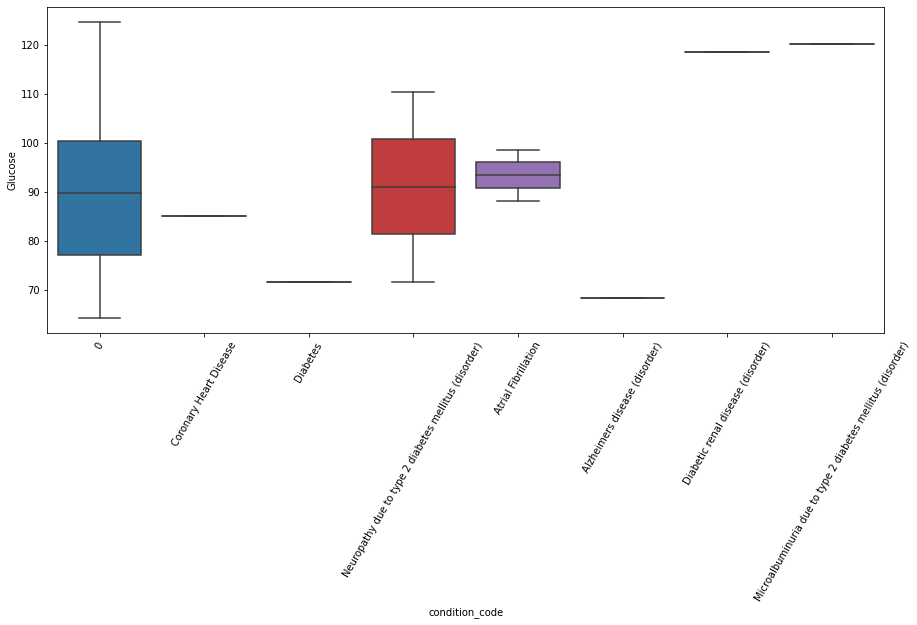

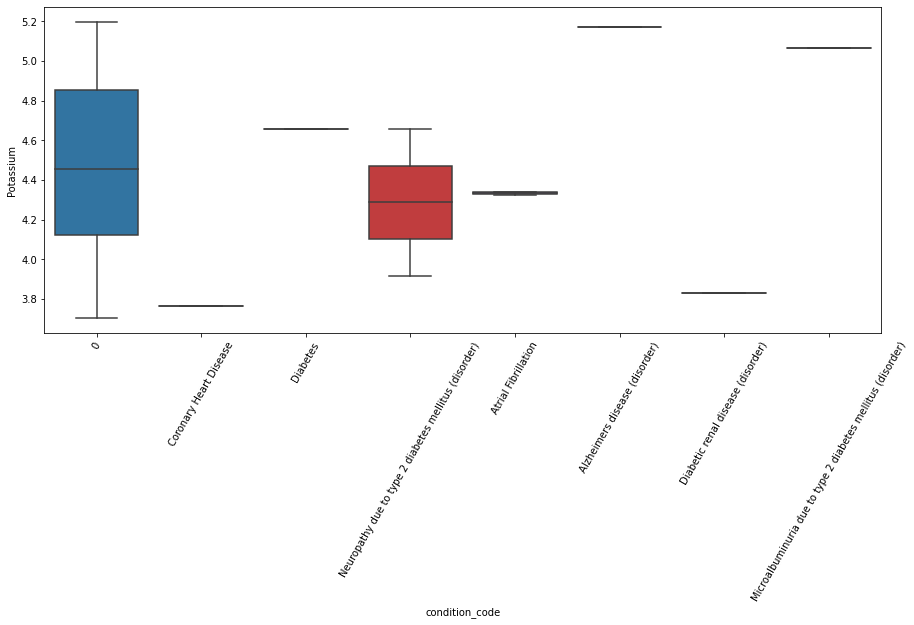

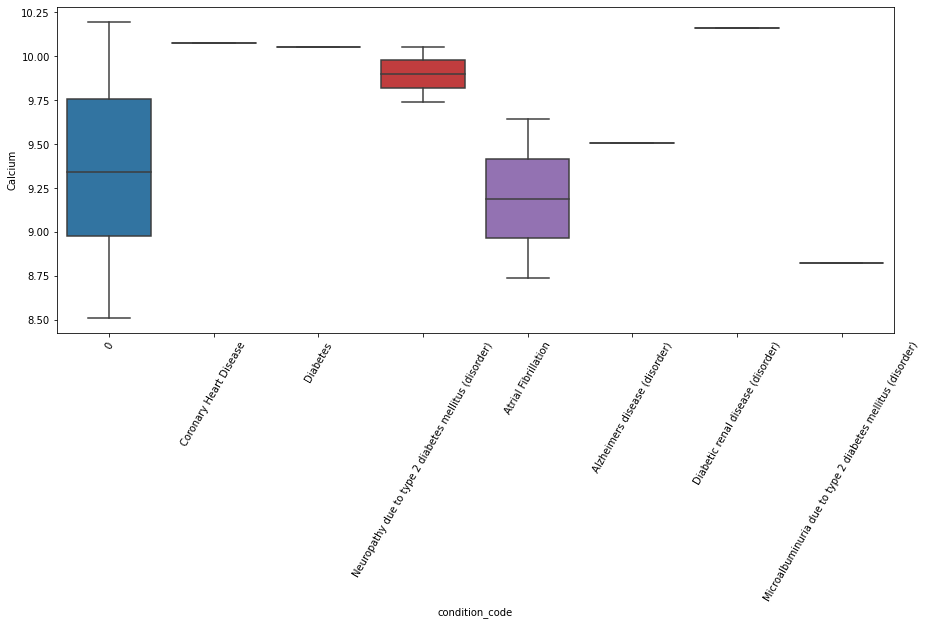

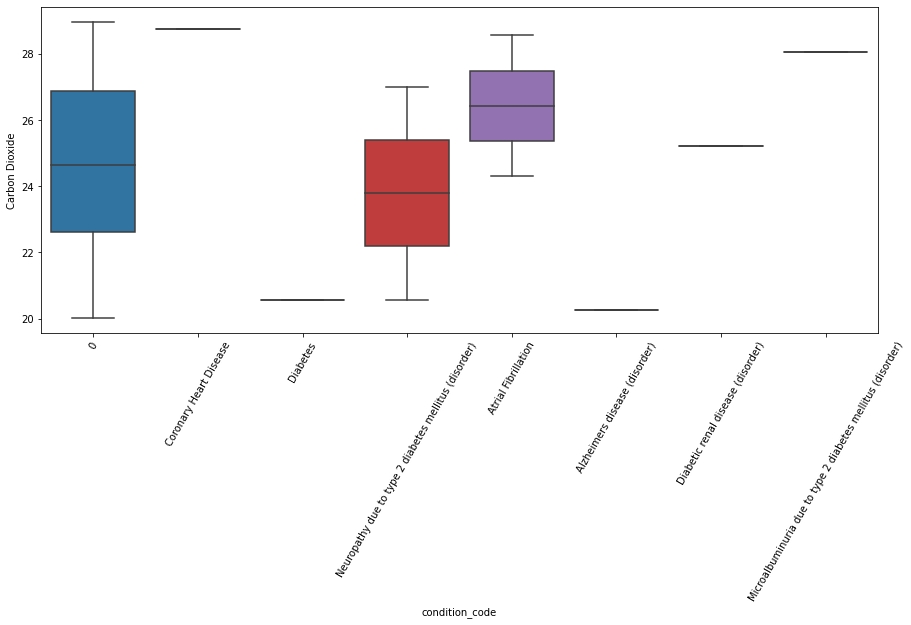

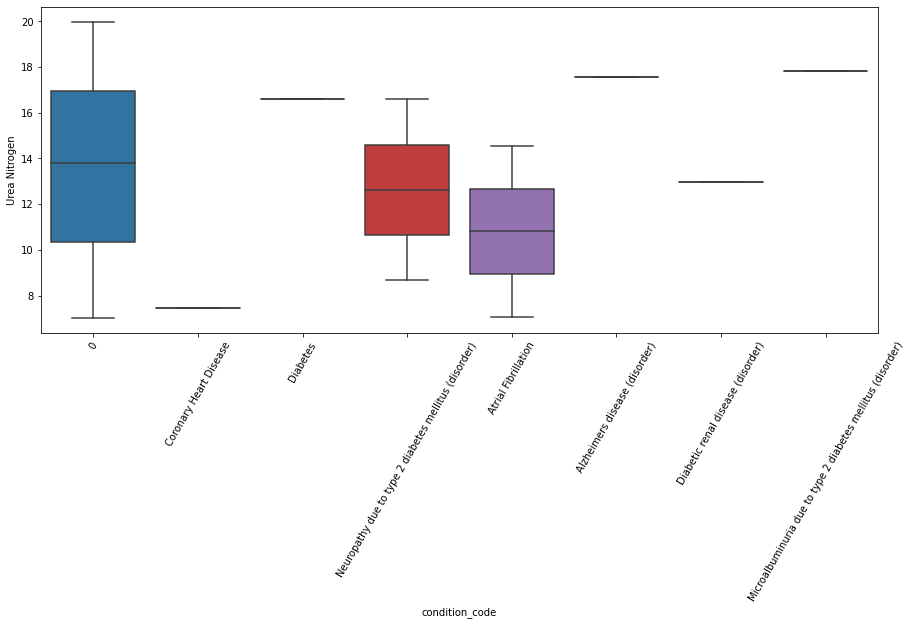

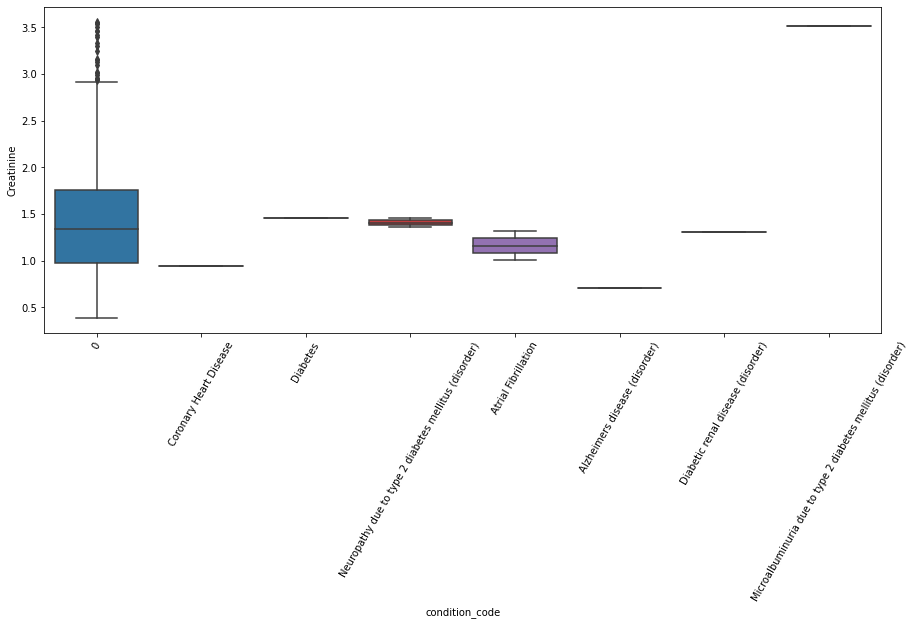

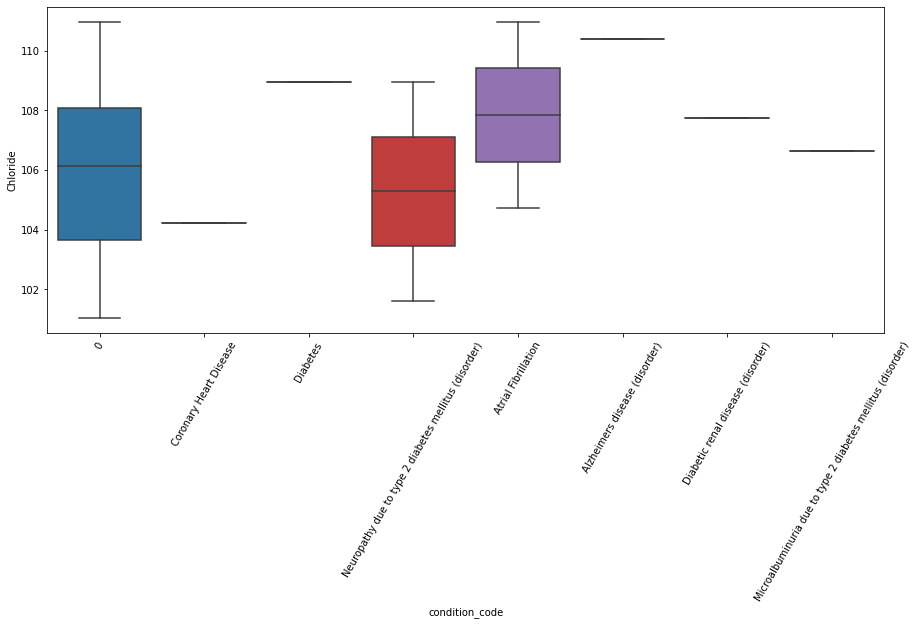

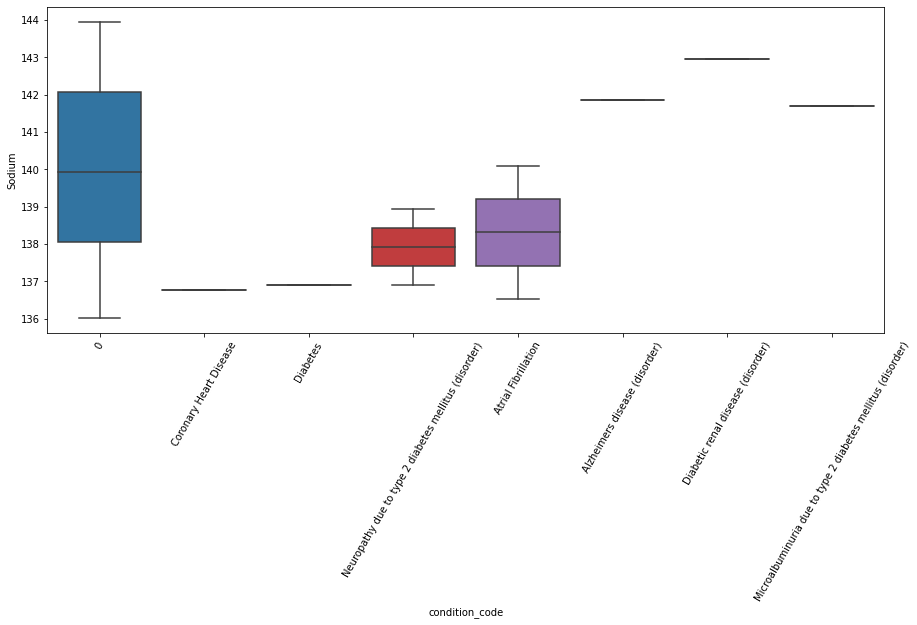

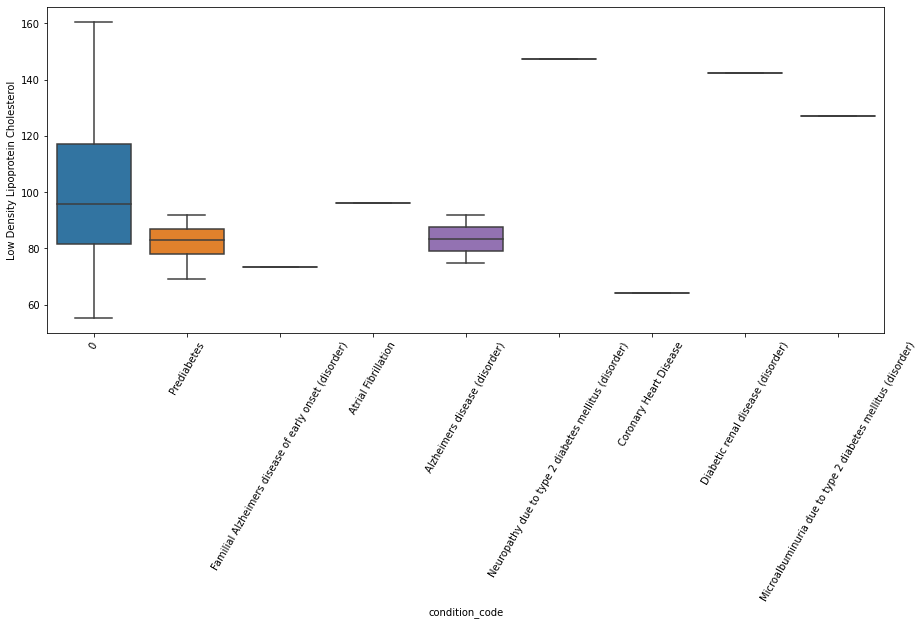

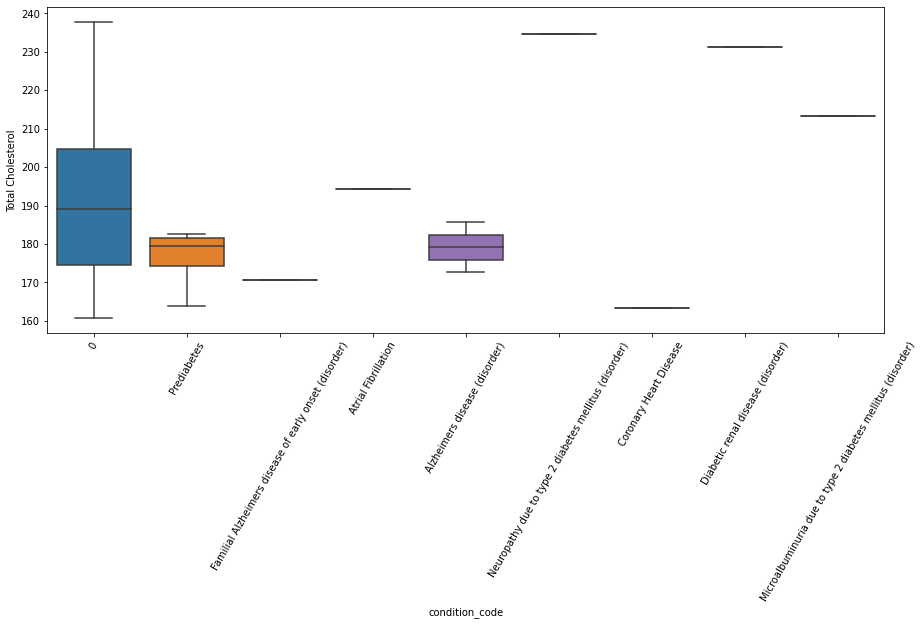

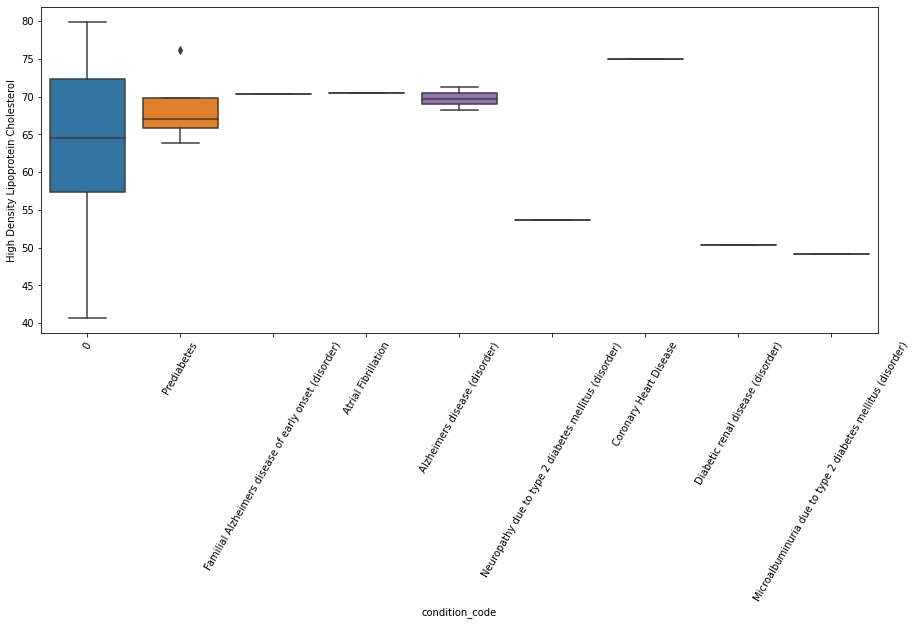

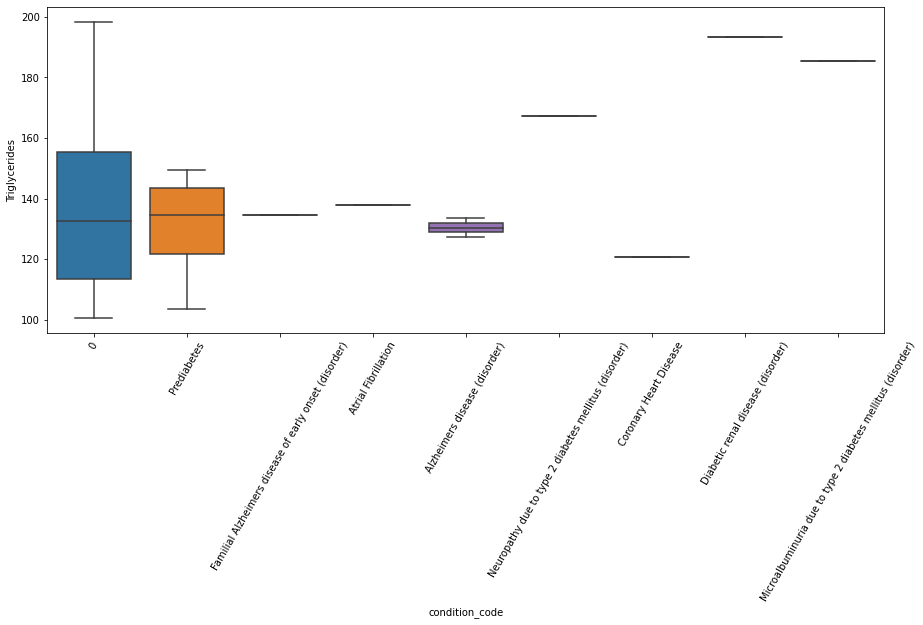

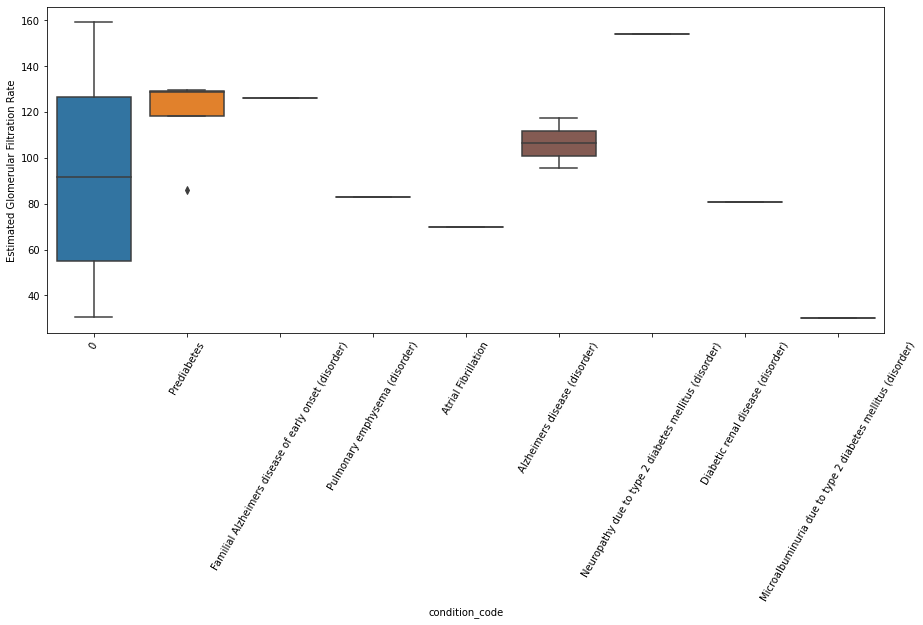

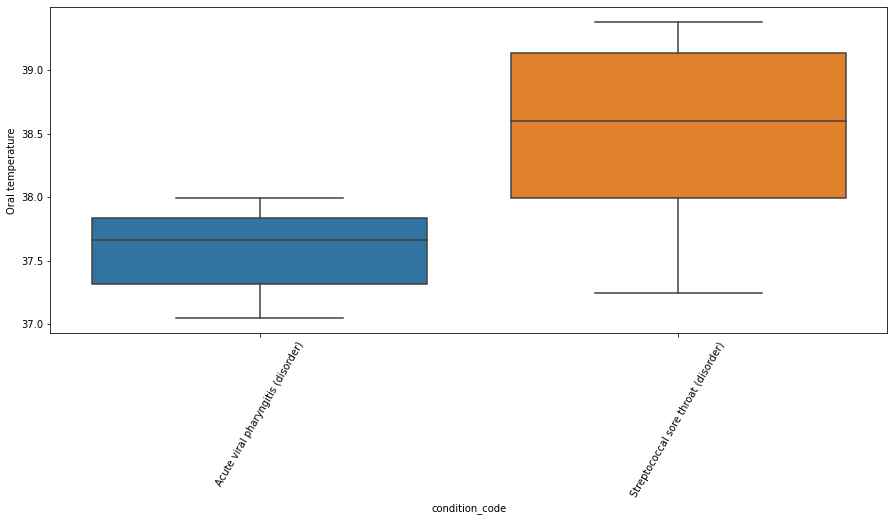

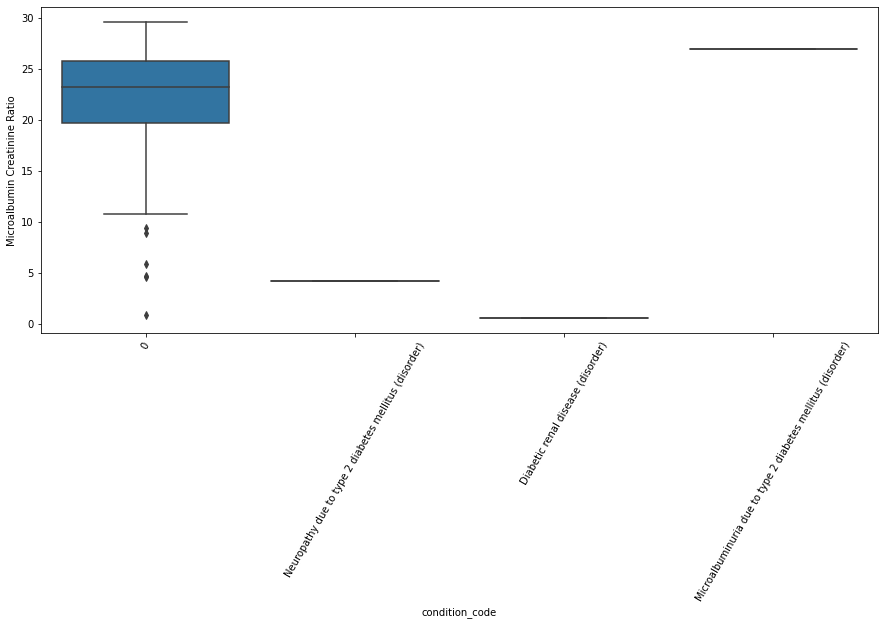

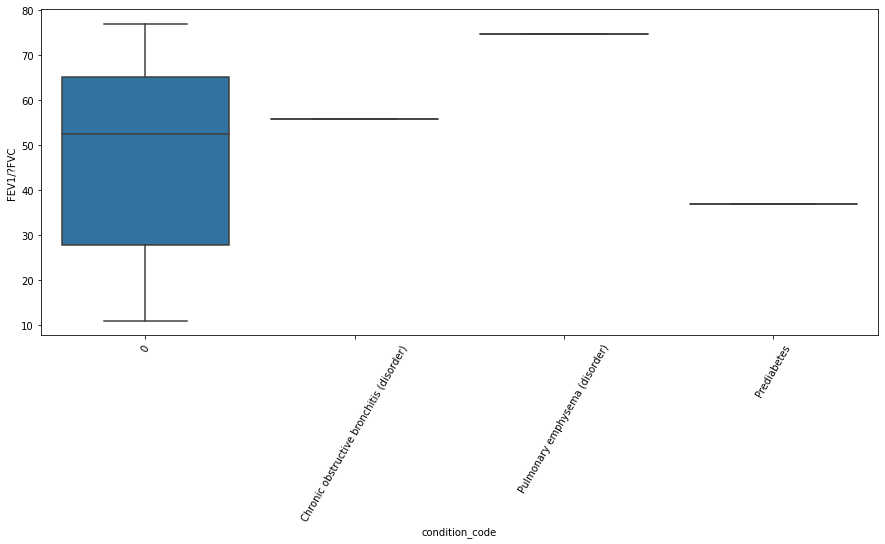

In [55]:
#Evaluating pre-conditions of patients and observations made
obs_cols = list(observation_df.observation_code.value_counts().reset_index(name="count").query("count > 40")["index"])

for i in list(obs_cols):
    onc_analysis = condition_analysis.loc[(condition_analysis['observation_code']==i)&(condition_analysis['condition_code'].notnull()),['observation_value','condition_code']]
    box_plot(onc_analysis,'condition_code','observation_value','condition_code',i)

Box plots are made to understand the spread of each value and their range

Most interesting observation : People with Hypertension and Coronary Heart Disease have good BMI's within 20-22 range. This could be because of bad lipid profile or higher cholestrol levels amongst population

People with diabetes have higher body weights and higher BMIs

Creatinine levels highest for patients with Microalbimuniria probably because of dysfunctional kidneys due to diabetes

People with nueropathy have the least amount of sodium levels

People with coronary heart diseases have the highest Carbondioxide. Smoking could be a cause? 

#### Common medication for breathing problems

In [80]:
breathing_problems = ['Viral sinusitis (disorder)','Acute viral pharyngitis (disorder)','Acute bronchitis (disorder)',
                     'Asthma','Streptococcal sore throat (disorder)','Acute bacterial sinusitis (disorder)']

sinus_patients = df[df['encounter_reason'].isin(breathing_problems)]

In [81]:
sinus_patients['medication_type'].value_counts()

Acetaminophen 160 MG                                    39
 Amoxicillin 250 MG / Clavulanate 125 MG [Augmentin]    29
Dextromethorphan Hydrobromide 1 MG/ML                   15
Penicillin V Potassium 250 MG                           13
Penicillin V Potassium 500 MG                            5
Name: medication_type, dtype: int64

#### Other visualisations

In [85]:
#Visualising readmissions graph
Readmissions=nx.DiGraph()
for i in readmissions.index:
   Readmissions.add_edge(readmissions.first_encounter[i],readmissions.freq_encounter[i])  

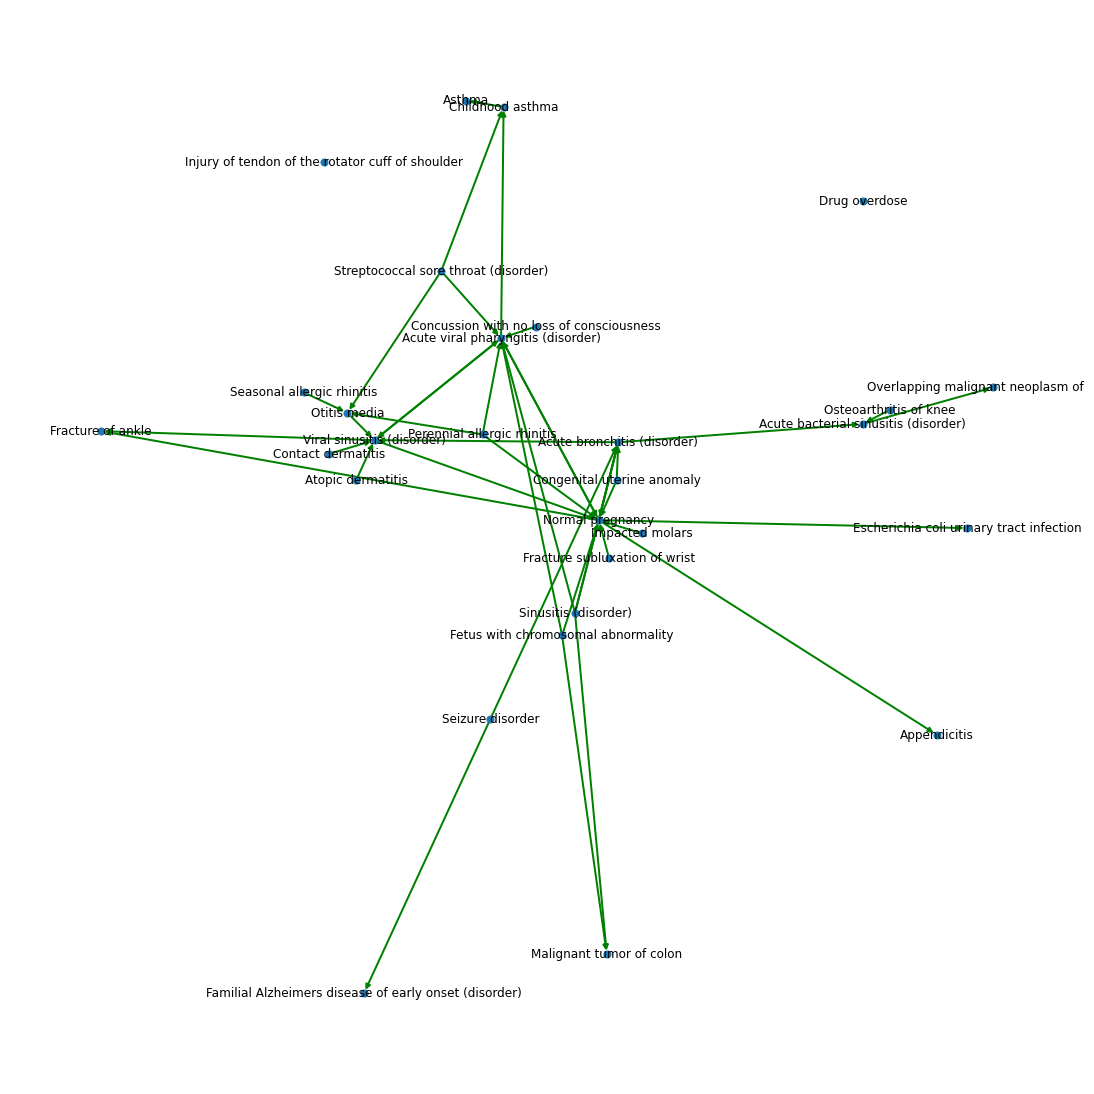

In [86]:
#visualize the procedure-encounter newtork
plt.figure(figsize = (15,15))
nx.draw(Readmissions,node_size=50,width=2,edge_color='green',with_labels=True)

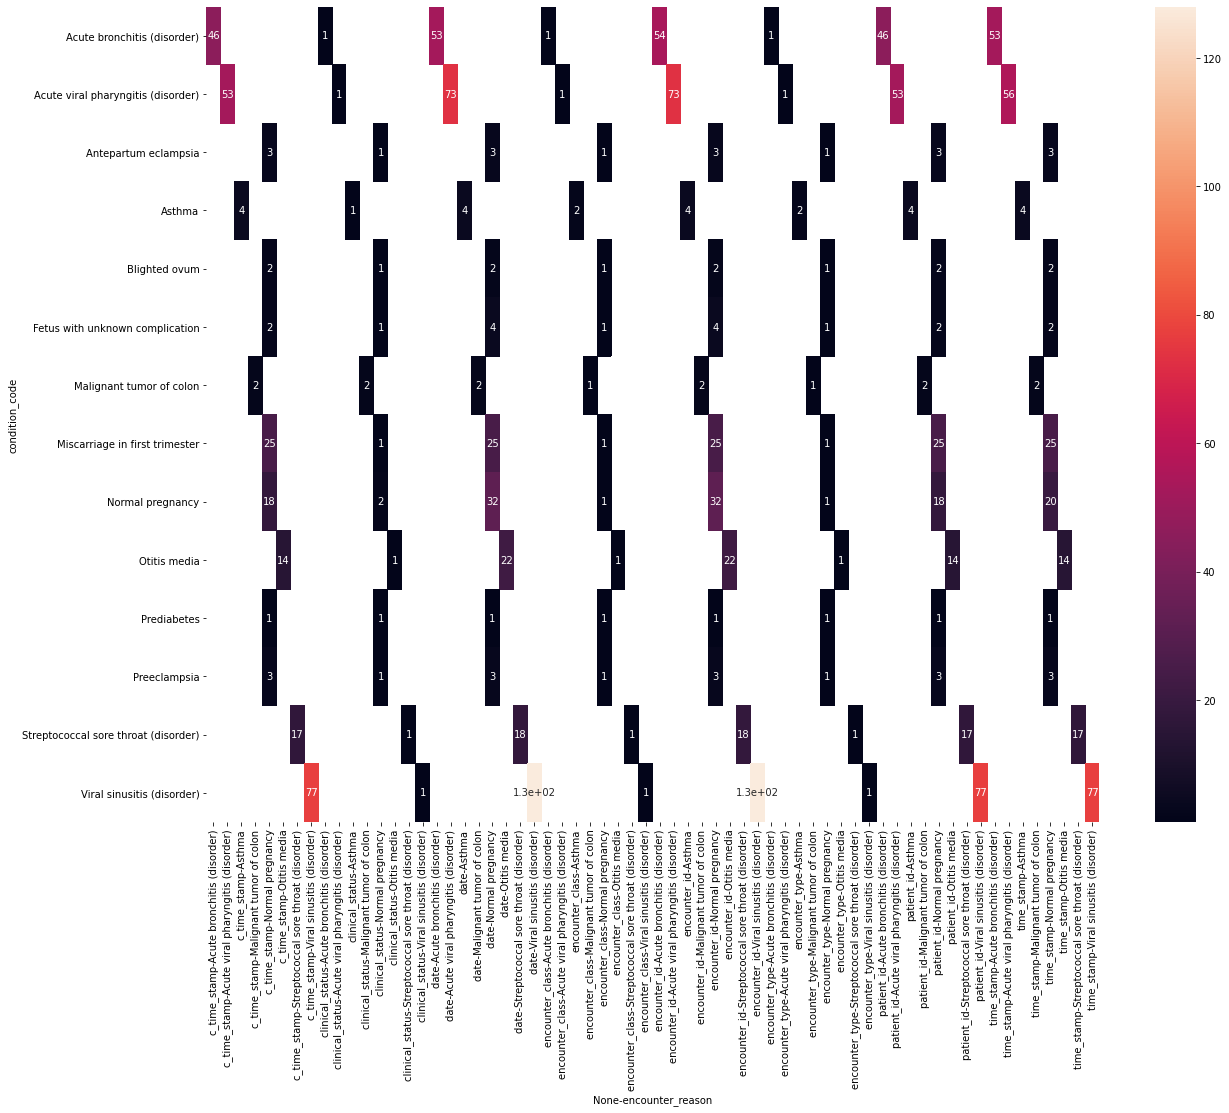

In [87]:
#Visualising comorbidities counts
comorbidities_plot = comorbidities[comorbidities.groupby('encounter_reason')['encounter_reason'].transform('size') > 15].pivot_table(index='condition_code', columns='encounter_reason', aggfunc=lambda x: len(x.unique()))
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(comorbidities_plot, annot=True)
plt.show()

In [16]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import modules as m
import new_populate as n
import sqlalchemy
    

def vectorize():
    #Accessing key-vault file
    with open('config.yaml','r') as yaml_file:
        config = yaml.load(yaml_file, Loader=yaml.Loader)
        Conf = config['database']
        user = Conf['uid']
        password = Conf['password']
        
    conn = pyodbc.connect(
        'Driver={ODBC Driver 17 for SQL Server};'
        #'Driver={/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.5.so.2.1};'
        'Server=localhost;'
        'Database=master;'
        'uid=%s;'
        'pwd=%s;'
        'MARS_Connection=Yes' % (user,password))

    #Accessing data dictionary

    patient_feature = m.sql_reader("patient_timeline",conn)


    drop_cols = ['observation_unit','component_unit','date','time_stamp']

    patient_feature = patient_feature.drop(columns = drop_cols)

    patient_feature['component_value'] = patient_feature['component_value'].replace(['nan', 'None'], None)


    patient_feature['observation_value'] = patient_feature['observation_value'].astype(float)
    patient_feature['component_value'] = patient_feature['component_value'].astype(float)
    patient_feature['dose_quantity'] = patient_feature['dose_quantity'].astype(float)

    cat_cols = ['encounter_class','encounter_type','encounter_reason','clinical_status','procedure_code',
           'procedure_reason','observation_code','observation_value','observation_valueString','obervation_coding',
           'component_code','observation_text','dose_quantity','dose_additional_instruction','medication_type',
           'dose_repeat_timeperiod','dose_repeat_frequency','dose_as_needed','dose_repeat_timeunit','dose_sequence',
           'dose_add_instruct_text']

    patient_feature = pd.get_dummies(data = patient_feature, columns= cat_cols)


    feature_vector = patient_feature.values

    print(feature_vector[:10])

In [17]:
vectorize()

[['a00306e7bc92f4e81adbe47c2ab34ddad' 'abf228bc3f3c648eb8b1f16051d8eaba2'
  'Miscarriage in second trimester' ... 0 1 0]
 ['a00306e7bc92f4e81adbe47c2ab34ddad' 'abf228bc3f3c648eb8b1f16051d8eaba2'
  '0' ... 0 1 0]
 ['a00306e7bc92f4e81adbe47c2ab34ddad' 'a38373dbf82c446d99cfee246b7436fcc'
  'Miscarriage in first trimester' ... 0 1 0]
 ...
 ['a00306e7bc92f4e81adbe47c2ab34ddad' 'ab32ad53586d94b31bda77ea1a5d7e363'
  '0' ... 0 1 0]
 ['a00306e7bc92f4e81adbe47c2ab34ddad' 'a3c686a5ee34c42f49fb0bd3dd51cee2e'
  '0' ... 0 1 0]
 ['a00306e7bc92f4e81adbe47c2ab34ddad' 'a3c686a5ee34c42f49fb0bd3dd51cee2e'
  '0' ... 0 1 0]]


In [37]:
#Importing needed libraries 
import pyodbc
import pandas as pd
import numpy as np
import yaml
import modules as m
import new_populate as n

#Creating schema for patient timeline dataframe
n.create_schema()

#Reading username-password from config file

with open('config.yaml','r') as yaml_file:
    config = yaml.load(yaml_file, Loader=yaml.Loader)

    Conf = config['database']
    user = Conf['uid']
    password = Conf['password']

    conn = pyodbc.connect(
        #'Driver={/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.5.so.2.1};'
        #Changing driver for MAC
        'Driver={ODBC Driver 17 for SQL Server};'
        'Server=localhost;'
        'Database=master;'
        'uid=%s;'
        'pwd=%s;'
        'MARS_Connection=Yes' % (user,password))

#Defining a function to insert rows into patient timeline dataframe after all merges and preprocessing
def load_data(df):
    cursor = conn.cursor()
     
    #Inserting each row 
    for index, row in df.iterrows():
        cursor.execute("INSERT INTO patient_timeline([patient_id],[encounter_id],[date],[time_stamp],[encounter_class],[encounter_type],[encounter_reason],[condition_code],[clinical_status],[procedure_reason],[procedure_code],[observation_code],[observation_unit],[observation_value],[observation_valueString],[obervation_coding] ,[component_code],[component_value],[component_unit],[observation_text],[dose_quantity],[dose_additional_instruction],[medication_type],[dose_repeat_timeperiod],[dose_repeat_frequency],[dose_as_needed],[dose_repeat_timeunit],[dose_sequence],[dose_add_instruct_text]) values(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", row['patient_id'], row['encounter_id'], row['date'], row['time_stamp'],row['encounter_class'],row['encounter_type'],row['encounter_reason'],row['condition_code'],row['clinical_status'],row['procedure_reason'],row['procedure_code'],row['observation_code'],row['observation_unit'],row['observation_value'],row['observation_valueString'],row['obervation_coding'],row['component_code'],row['component_value'],row['component_unit'],row['observation_text'],row['dose_quantity'],row['dose_additional_instruction'],row['medication_type'],row['dose_repeat_timeperiod'],row['dose_repeat_frequency'],row['dose_as_needed'],row['dose_repeat_timeunit'],row['dose_sequence'],row['dose_add_instruct_text'])
        conn.commit()
    #Closing connection
    cursor.close()
    conn.close()
    
#Running the merge and preprocessing steps
def main():

    #Accessing data dictionary
    col_info = pd.read_csv('col_info.csv')

    #Loading datasets directly from MSSQL 
    encounter_df = m.sql_reader("encounter",conn)
    condition_df = m.sql_reader("condition",conn)
    procedure_df = m.sql_reader("procedure",conn)
    observation_df = m.sql_reader("observation",conn)
    medicationrequest_df = m.sql_reader("medicationrequest",conn)

    #Creating time-stamp for encounter and procedure tables
    encounter_df['time_stamp'] = encounter_df.apply(m.encounter_timestamp, axis=1)
    procedure_df['p_time_stamp'] = procedure_df.apply(m.procedure_timestamp, axis=1) 
    
    #Renaming columns using data dictionary
    m.col_rename(col_info,encounter_df,'encounter_df')
    m.col_rename(col_info,condition_df,'condition_df')
    m.col_rename(col_info,procedure_df,'procedure_df')
    m.col_rename(col_info,observation_df,'observation_df')
    m.col_rename(col_info,medicationrequest_df,'medicationrequest_df')

    #Creating date-time columns for each table
    m.extract_datetime(encounter_df,'time_stamp')
    m.extract_datetime(condition_df,'c_time_stamp')
    m.extract_datetime(procedure_df,'p_time_stamp')
    m.extract_datetime(observation_df,'o_time_stamp')
    m.extract_datetime(medicationrequest_df,'m_time_stamp')

    #Merging datasets after subsetting columns and specifying joining parameters 
    encounter_params = ['patient_id','encounter_id','date','time_stamp','encounter_class','encounter_type','encounter_reason']
    condition_params = ['patient_id','encounter_id', 'condition_code','date','c_time_stamp','clinical_status']
    procedure_params = ['patient_id','encounter_id','procedure_reason','date','p_time_stamp','procedure_code']
    observation_params = ['patient_id','encounter_id','date','o_time_stamp','observation_code','observation_unit',
                      'observation_value','observation_valueString','obervation_coding','component_code',
                      'component_value','component_unit','observation_text']
    medication_params = ['patient_id','encounter_id','m_time_stamp','date','dose_quantity','dose_additional_instruction',
                     'medication_type','dose_repeat_timeperiod','dose_repeat_frequency','dose_as_needed',
                     'dose_repeat_timeunit','dose_sequence','dose_add_instruct_text']

    on_condition = ['patient_id','encounter_id','date']

    join_type = "left"

    #Merge steps
    df = m.merge_op(encounter_df,condition_df,encounter_params,condition_params,on_condition,join_type)
    df_params = m.update_params(df)
    df = m.merge_op(df,procedure_df,df_params,procedure_params,on_condition,join_type)
    df_params = m.update_params(df)
    df = m.merge_op(df,observation_df,df_params,observation_params,on_condition,join_type)
    df_params = m.update_params(df)
    df = m.merge_op(df,medicationrequest_df,df_params,medication_params,on_condition,join_type)
    
    #Converting the dataframe into longitudnal having each patient_id and their entire timeline in a vertical format and sorting by patient id and timeline
    df = pd.concat([df[encounter_params], 
                df[condition_params].rename(columns={'c_time_stamp': 'time_stamp'}),
                df[procedure_params].rename(columns={'p_time_stamp': 'time_stamp'}),
                df[observation_params].rename(columns={'o_time_stamp': 'time_stamp'}),
                df[medication_params].rename(columns={'m_time_stamp':'time_stamp'})]).dropna(how='all').sort_values(['patient_id','date','time_stamp','encounter_id'], ascending=[True, True, True, True])
    
    #Dropping time_stamps with NA values
    df = df.dropna(axis=0, subset=['time_stamp'])
    
    #Filling NA's with 0  
    df = df.fillna(value=0)
    
    print(df.shape)
    
    
    for index,row in df.iterrows():
        print(row['patient_id'])
        break
    
    load_data(df)
    
main()

Schema Created!
(31492, 29)
a00306e7bc92f4e81adbe47c2ab34ddad


SystemError: <class 'pyodbc.Error'> returned a result with an error set